In [2]:
import numpy as np
from keras import Model
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, LeakyReLU, UpSampling2D
import keras.backend as K
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import random
import copy
import cv2
from contextlib import redirect_stdout
from sklearn.manifold import TSNE

2023-09-29 09:46:45.747761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
@keras.utils.register_keras_serializable()
class ReparameterizationLayer(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super(ReparameterizationLayer, self).get_config()

In [4]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        self.encoder = encoder
        self.decoder = decoder
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

        

# Pretprocesiranje podataka

In [5]:

# Potrebno je prilagoditi putanju celebA skupa podataka koga možete preuzeti sa adrese https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

def preprocess_data(path='celebA', desired_width=128, desired_height=128):
    # Nađi putanju na sopstvenom sistemu
    cascade_path = 'venv/lib/python3.9/site-packages/cv2/data/haarcascade_frontalcatface.xml'
    face_cascade = cv2.CascadeClassifier(cascade_path)
    images = []
    for file_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path, file_name)
        img = cv2.imread(img_path)

        # Detektuj sva lica na slici - jedno isto lice može biti detektovano više puta
        faces = face_cascade.detectMultiScale(img, scaleFactor=1.05, minSize=(15, 15), maxSize=(200, 200))
        for i, (x, y, w, h) in enumerate(reversed(faces)):
            # Centriraj lice tako da sredina detekotovanog lica bude sredina kropovane slike
            y_a = int(max((y+((h-desired_height)/2),0)))
            y_b = y_a + desired_height

            x_a = int(max((x+((w-desired_width)/2), 0)))
            x_b = x_a + desired_width

            # Kropuj lica
            face = img[y_a:y_b, x_a:x_b]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = face.astype("float32") / 255.0
            if face.shape == (desired_width, desired_height, 3):
                images.append(cv2.resize(face, (64, 64)))
                break

    # Čuvaj lica u odgovarajućem folderu
    images = np.array(images)
    image_folder = os.path.basename(path)
    save_folder = os.path.join("data", image_folder)
    
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
        
    np.save(os.path.join(save_folder, "images.npy"), images)

def load_preprocess_images():
    #Slike su već podeljene sa 255.0
    images = np.load("data/celebA/images.npy")
    return images

In [110]:

# Da biste napravili podatke, potrebno je da u repozitorijumu imate celebA skup podataka i pozovete funkciju preprocess_data
# cascade_path u ovoj funkciji treba zameniti sa putajom do haarcascade_frontalcatface.xml na vašem sistemu
# preprocess_data()

# Plotovanje

In [36]:
def plot_generated_images(vae, rows, columns, latent_space_dim, latent_samples=None):
    if latent_samples is None:
        # Semplujemo iz standardne normalne raspodele
        latent_samples = np.random.randn(rows * columns, latent_space_dim)

    generated_images = vae.decoder.predict(latent_samples)
    fig, axs = plt.subplots(rows, columns, figsize=(9, 9))
    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            ax = axs[i, j]
            ax.imshow(generated_images[index].reshape(input_shape))
            ax.axis('off')
    plt.show()

def plot_sample_images(vae, rows, columns):

    images = load_preprocess_images()
    
    selected_indices = random.sample(range(len(images)), rows * columns)
    selected_images = images[selected_indices]

    fig, axs = plt.subplots(rows, columns, figsize=(9, 9))
    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            ax = axs[i, j]
            ax.imshow(selected_images[index].reshape(input_shape))
            ax.axis('off')
    plt.show()

    samples = vae.encoder.predict(selected_images)
    return samples

def plot_faces_with_changes(vae, seed=7, face_num=9, sample_range_start=-5.0, sample_range_end=5.0):
    images = load_preprocess_images()

    seed %= images.shape[0]
    image = images[seed]
    latent_representation = vae.encoder.predict(np.array([image]))
    changing_attribute = np.linspace(start=sample_range_start, stop=sample_range_end, num=face_num)

    changing_attribute_indices = random.sample(range(0,100), face_num)
    changing_attributes_num = len(changing_attribute_indices)
    
    fig, axs = plt.subplots(changing_attributes_num, face_num, figsize=(12, 12))
    for i, change in enumerate(changing_attribute_indices):
        fresh_face = copy.deepcopy(latent_representation[0])
        for j in range(face_num):
            fresh_face[0][change] = changing_attribute[j]
            img = vae.decoder.predict(fresh_face)[0]
            ax = axs[i, j]
            ax.imshow(img.reshape(input_shape))
            ax.axis('off')

    plt.show()

# Čuvanje i učitavanje modela

In [7]:
def save_vae(vae, folder_path):
    folder_path = os.path.join("saved_models", folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    doc_path = os.path.join(folder_path, 'doc.txt')
    with open(doc_path, 'a') as doc:
        
        doc.write(f'epochs: {epochs}\nbatch_size: {batch_size}\nlatent_space_dim: {latent_space_dim}\nlearning_rate: {learning_rate}\n')
        with redirect_stdout(doc):
            vae.encoder.summary()
            vae.decoder.summary()

    encoder_folder_path = os.path.join(folder_path, 'encoder')
    if not os.path.exists(encoder_folder_path):
        os.makedirs(encoder_folder_path)
    encoder_path = os.path.join(encoder_folder_path, 'model.keras')
    vae.encoder.save(encoder_path)

    decoder_folder_path = os.path.join(folder_path, 'decoder')
    if not os.path.exists(decoder_folder_path):
        os.makedirs(decoder_folder_path)
    decoder_path = os.path.join(decoder_folder_path, 'model.keras')
    vae.decoder.save(decoder_path)

def load_vae(folder_path):
    folder_path = os.path.join("saved_models", folder_path)
    path = os.path.join(folder_path,'vae.keras')
    encoder_path = os.path.join(folder_path, 'encoder', 'model.keras')
    decoder_path = os.path.join(folder_path, 'decoder', 'model.keras')
    encoder = keras.models.load_model(encoder_path)
    decoder = keras.models.load_model(decoder_path)
    vae = VAE(encoder, decoder)
    return vae

# Trening drugog modela

In [8]:
# Encoder
input_shape = (64, 64, 3)
latent_space_dim = 100
beta = tf.Variable(1.0, trainable=False)

encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(filters=64, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(filters=128, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(filters=256, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# save shape for decoder reshape layer
conv_shape = K.int_shape(x)[1:]
        
x = Flatten()(x)

z_mean = Dense(units=latent_space_dim, name='mean')(x)
z_log_var = Dense(latent_space_dim, name='log_variance')(x)
z = ReparameterizationLayer(name='encoder_reparametrization')([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_input, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
decoder_input = Input(shape=(latent_space_dim,), name='decoder_input')

num_neurons = np.prod(conv_shape)
x = Dense(units=num_neurons, name='decoder_dense', activation='relu')(decoder_input)
x = Reshape(target_shape=conv_shape)(x)

x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

decoder_output = Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x)
decoder = keras.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           1568      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)           0         ['batch_normalization[0]

In [54]:
images = load_preprocess_images()
vae = VAE(encoder, decoder)
learning_rate=0.0005
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
epochs = 10
batch_size = 64
history = vae.fit(images, epochs=epochs, batch_size=batch_size)
vae_folder_name = f'celebA_{epochs}_epochs_{batch_size}_batch_size_{latent_space_dim}_latent_dim_vae'
save_vae(vae, vae_folder_name)

Epoch 1/10
1639/1639 [==============================] - 338s 204ms/step - loss: 339.7144 - reconstruction_loss: 193.0047 - kl_loss: 47.2955
Epoch 2/10
1639/1639 [==============================] - 346s 211ms/step - loss: 183.8461 - reconstruction_loss: 129.1088 - kl_loss: 52.2705
Epoch 3/10
1639/1639 [==============================] - 348s 212ms/step - loss: 175.9371 - reconstruction_loss: 122.0766 - kl_loss: 53.1213
Epoch 4/10
1639/1639 [==============================] - 348s 213ms/step - loss: 172.4570 - reconstruction_loss: 118.4250 - kl_loss: 53.6118
Epoch 5/10
1639/1639 [==============================] - 348s 212ms/step - loss: 170.4860 - reconstruction_loss: 115.9792 - kl_loss: 53.9103
Epoch 6/10
1639/1639 [==============================] - 348s 212ms/step - loss: 168.6186 - reconstruction_loss: 114.3207 - kl_loss: 54.0661
Epoch 7/10
1639/1639 [==============================] - 351s 214ms/step - loss: 167.8558 - reconstruction_loss: 113.0386 - kl_loss: 54.2064
Epoch 8/10
1639/1639

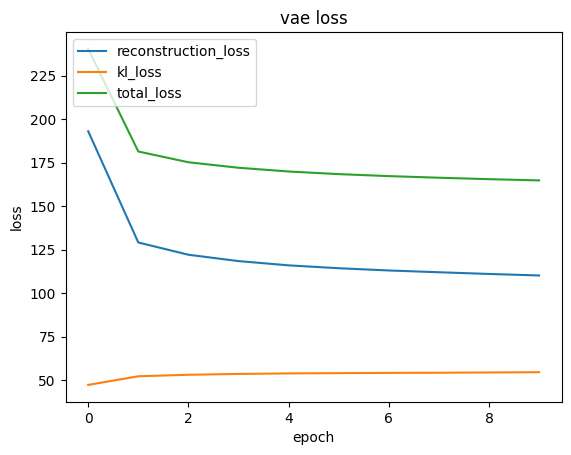

In [55]:
print(history)
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(history.history['loss'])
plt.title('vae loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['reconstruction_loss', 'kl_loss', 'total_loss'], loc='upper left')
plt.savefig(f'saved_models/{vae_folder_name}/plot.png')
plt.show()

313/313 [==============================] - 6s 19ms/step


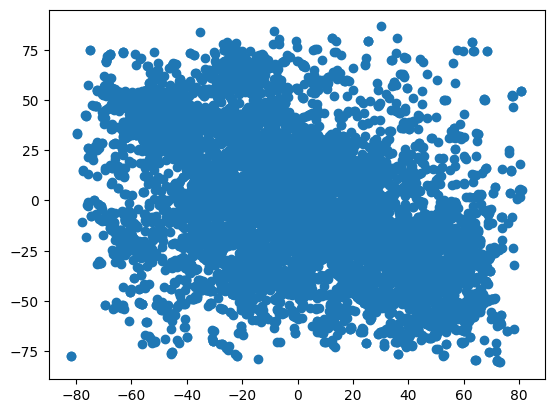

In [52]:
vae = load_vae('model2')
images = load_preprocess_images()[:10000]
latent_representation = np.array(vae.encoder.predict(images)[0])

latent_space_2d = TSNE(n_components=2, perplexity=10).fit_transform(latent_representation)
plt.scatter(latent_2d[:, 0], latent_space_2d[:, 1])
plt.savefig(f'saved_models/model2/latent_space_2d_plot.png')
plt.show()

# Trening prvog modela

In [104]:
# Encoder
input_shape = (64, 64, 3)
latent_space_dim = 128
beta = tf.Variable(1.0, trainable=False)

encoder_input = Input(shape=input_shape, name='encoder_input')
x = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu')(encoder_input)
x = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
x = Conv2D(filters=32, kernel_size=4, strides=2, padding='same', activation='relu')(x)

# save shape for decoder reshape layer
conv_shape = K.int_shape(x)[1:]
        
x = Flatten()(x)

z_mean = Dense(units=latent_space_dim, name='mean')(x)
z_log_var = Dense(latent_space_dim, name='log_variance')(x)
z = ReparameterizationLayer(name='encoder_reparametrization')([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_input, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
decoder_input = Input(shape=(latent_space_dim,), name='decoder_input')

num_neurons = np.prod(conv_shape)
x = Dense(units=num_neurons, name='decoder_dense')(decoder_input)
x = Reshape(target_shape=conv_shape)(x)

x = Dense(units=256, activation='relu', name='hidden_layer_1')(x)
x = Dense(units=256, activation='relu', name='hidden_layer_2')(x)

x = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu')(x)

decoder_output = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)
decoder = keras.Model(inputs=decoder_input, outputs=decoder_output, name='decoder')
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 32, 32, 32)           1568      ['encoder_input[0][0]']       
                                                                                                  
 conv2d_42 (Conv2D)          (None, 16, 16, 32)           16416     ['conv2d_41[0][0]']           
                                                                                                  
 conv2d_43 (Conv2D)          (None, 8, 8, 32)             16416     ['conv2d_42[0][0]']           
                                                                                            

In [11]:
images = load_preprocess_images()
vae = VAE(encoder, decoder)
learning_rate = 0.0005
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
epochs = 15 
batch_size = 64
history = vae.fit(images, epochs=epochs, batch_size=batch_size)
vae_folder_name = f'celebA_{epochs}_epochs_{batch_size}_batch_size_{latent_space_dim}_latent_dim_vae'
save_vae(vae, vae_folder_name)

Epoch 1/15
1639/1639 [==============================] - 273s 165ms/step - loss: 406.8295 - reconstruction_loss: 230.3313 - kl_loss: 45.5172
Epoch 2/15
1639/1639 [==============================] - 248s 151ms/step - loss: 193.9245 - reconstruction_loss: 138.2515 - kl_loss: 51.8370
Epoch 3/15
1639/1639 [==============================] - 242s 147ms/step - loss: 183.1637 - reconstruction_loss: 128.7169 - kl_loss: 53.0099
Epoch 4/15
1639/1639 [==============================] - 242s 148ms/step - loss: 178.0543 - reconstruction_loss: 123.7306 - kl_loss: 53.6447
Epoch 5/15
1639/1639 [==============================] - 243s 148ms/step - loss: 175.1266 - reconstruction_loss: 120.5577 - kl_loss: 53.8961
Epoch 6/15
1639/1639 [==============================] - 225s 137ms/step - loss: 172.9056 - reconstruction_loss: 118.3066 - kl_loss: 54.0385
Epoch 7/15
1639/1639 [==============================] - 209s 127ms/step - loss: 170.9795 - reconstruction_loss: 116.5220 - kl_loss: 54.1860
Epoch 8/15
1639/1639

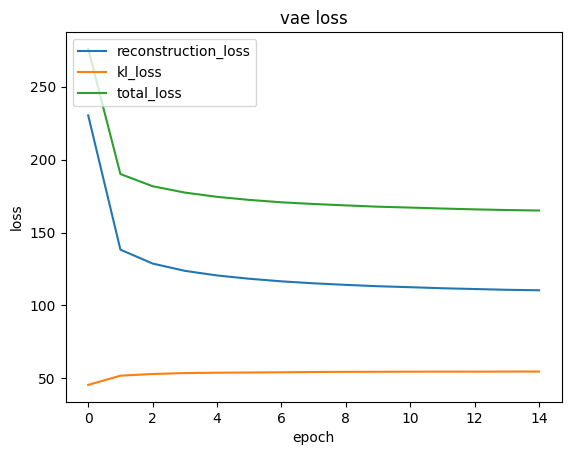

In [12]:
print(history)
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss']) 
plt.plot(history.history['loss'])
plt.title('vae loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['reconstruction_loss', 'kl_loss', 'total_loss'], loc='upper left')
plt.savefig(f'saved_models/{vae_folder_name}/plot.png')
plt.show()

313/313 [==============================] - 2s 5ms/step


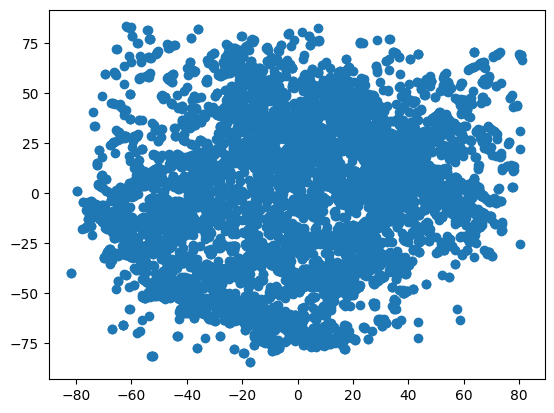

In [53]:
vae = load_vae('model1')
images = load_preprocess_images()[:10000]
latent_representation = np.array(vae.encoder.predict(images)[0])

latent_space_2d = TSNE(n_components=2, perplexity=10).fit_transform(latent_representation)

plt.scatter(latent_2d[:, 0], latent_space_2d[:, 1])
plt.savefig(f'saved_models/model1/latent_space_2d_plot.png')
plt.show()

# Demonstracija prvog modela

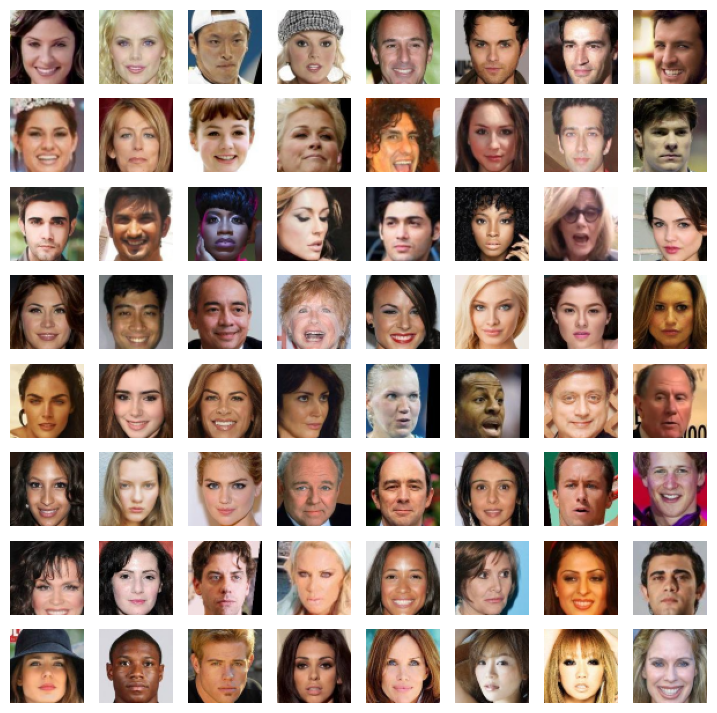

2/2 [==============================] - 0s 17ms/step


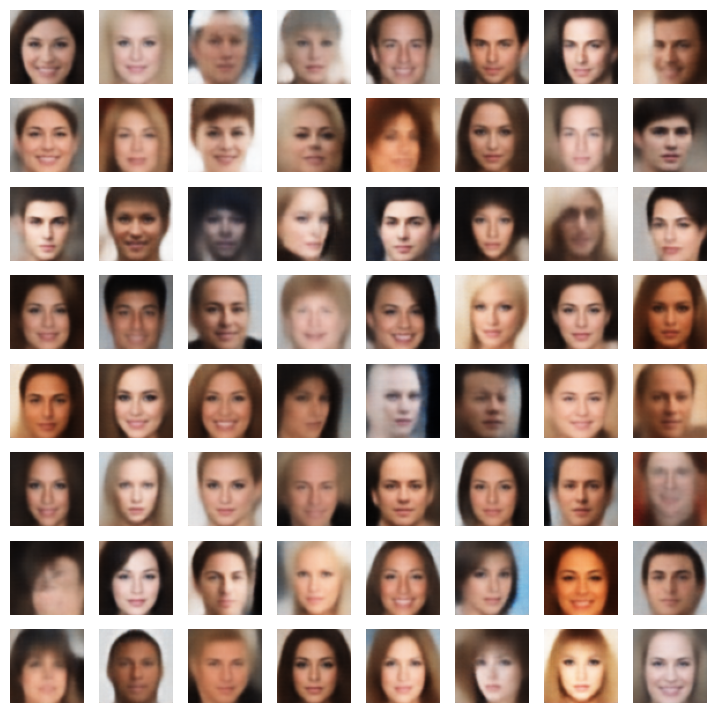

2/2 [==============================] - 0s 19ms/step


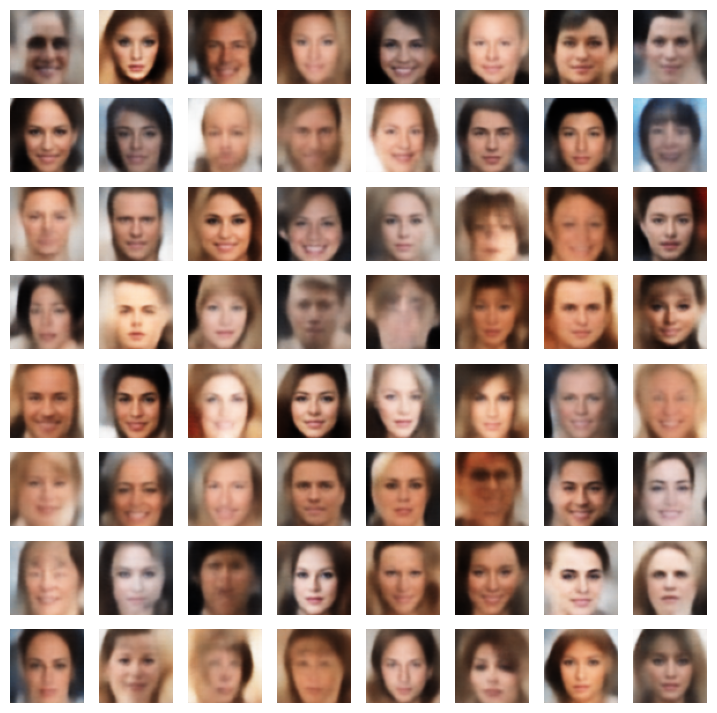

1/1 [==============================] - 0s 17ms/step


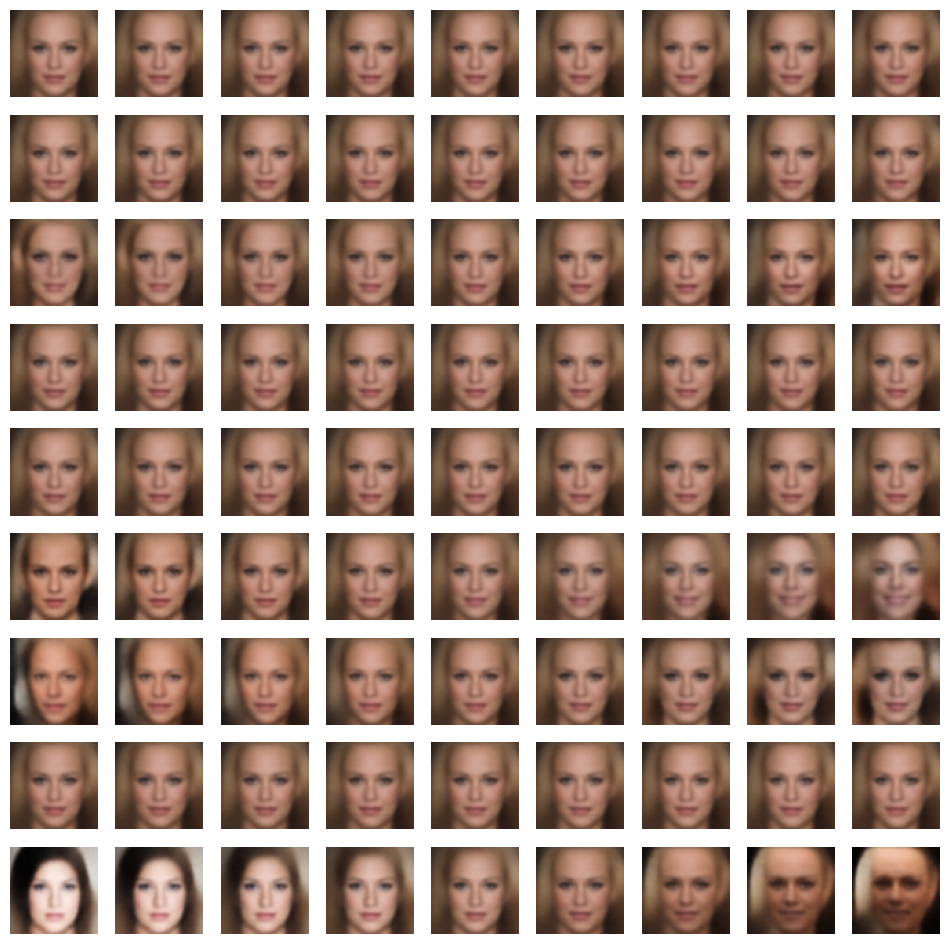

In [100]:
vae = load_vae('model1')

size = 8
# Originalne slike
samples = plot_sample_images(vae, size, size) 
# Rekonstrukcije
plot_generated_images(vae, size, size, latent_space_dim, latent_samples=samples[0])
# Generisane
plot_generated_images(vae, size, size, latent_space_dim=128)
# Menjanje nasumičnog broja
plot_faces_with_changes(vae, seed=4)

# Demonstracija drugog modela

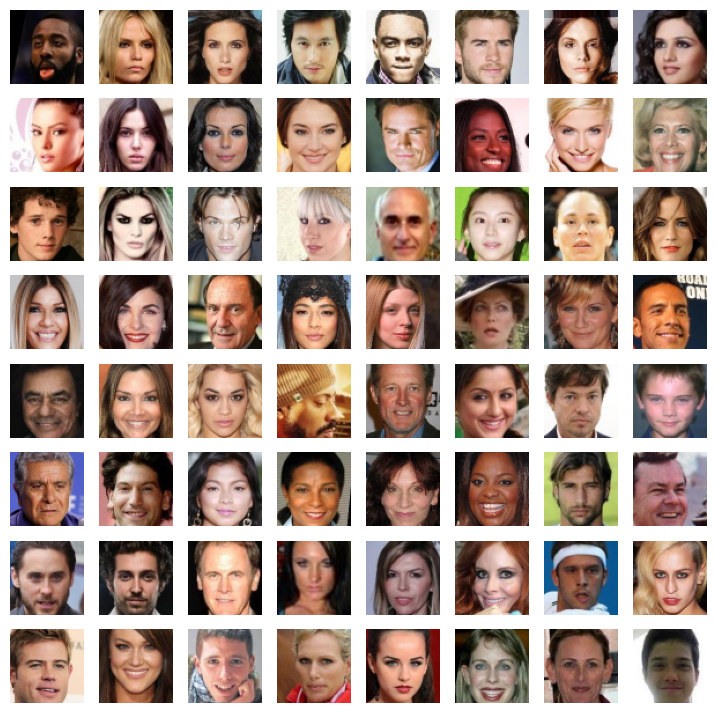

2/2 [==============================] - 0s 22ms/step


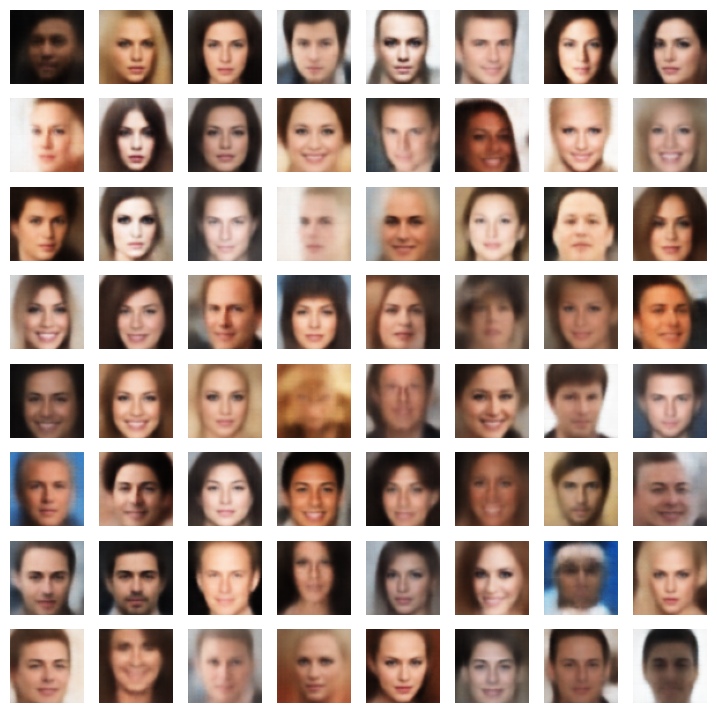

2/2 [==============================] - 0s 26ms/step


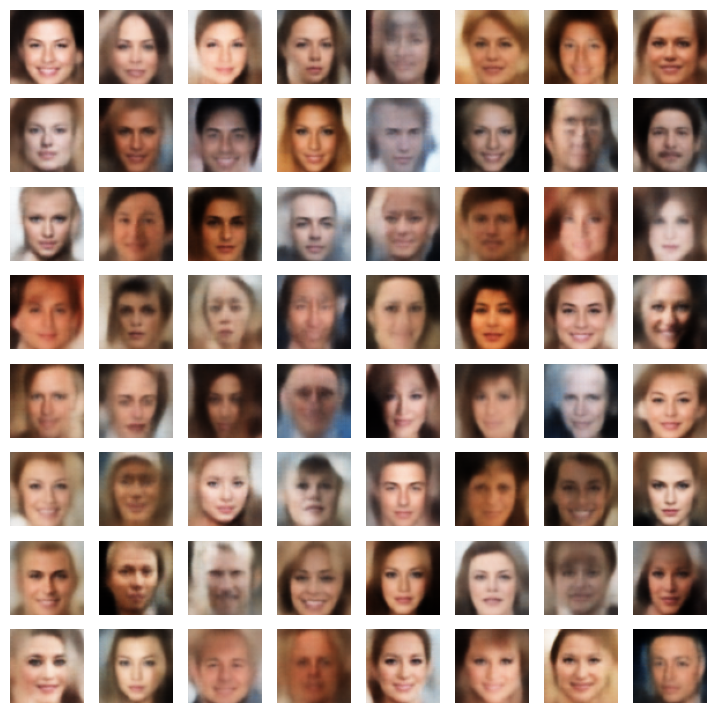

1/1 [==============================] - 0s 22ms/step


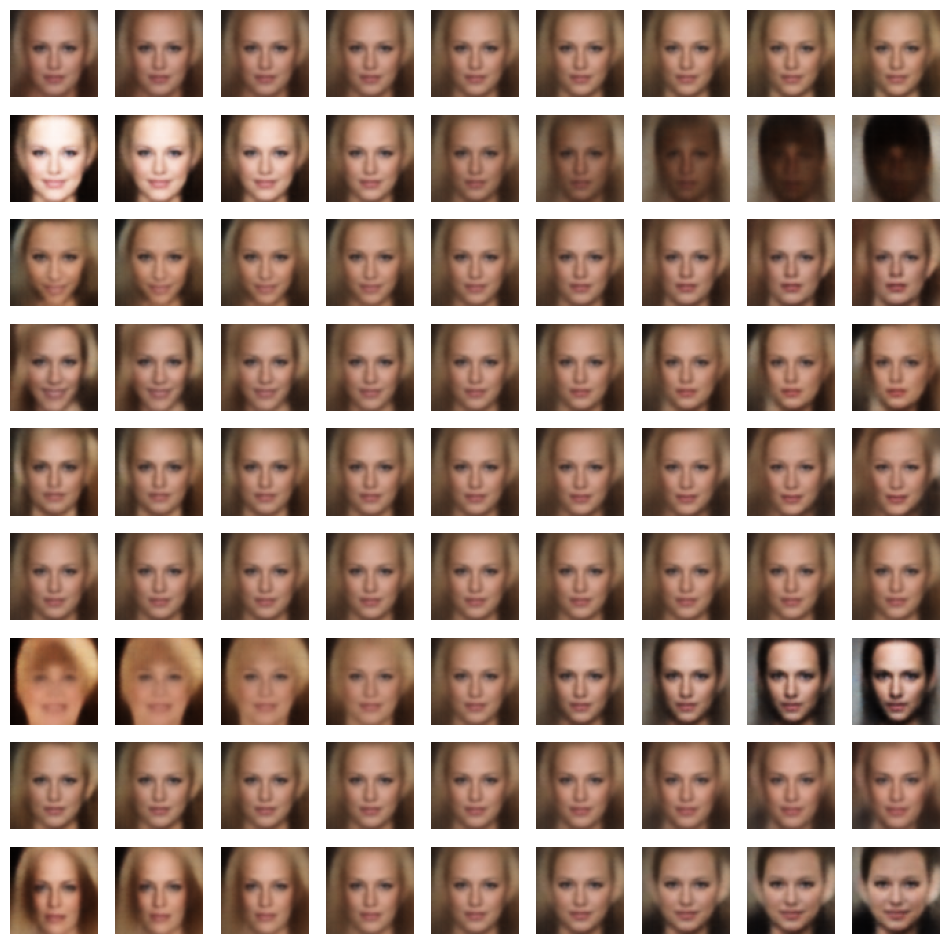

In [105]:
vae = load_vae('model2')

size = 8
# Originalne slike
samples = plot_sample_images(vae, size, size) 
# Rekonstrukcije
plot_generated_images(vae, size, size, latent_space_dim, latent_samples=samples[0])
# Generisane
plot_generated_images(vae, size, size, latent_space_dim=100)
# Menjanje nasumičnog broja
plot_faces_with_changes(vae, seed=4)

1/1 [==============================] - 0s 20ms/step


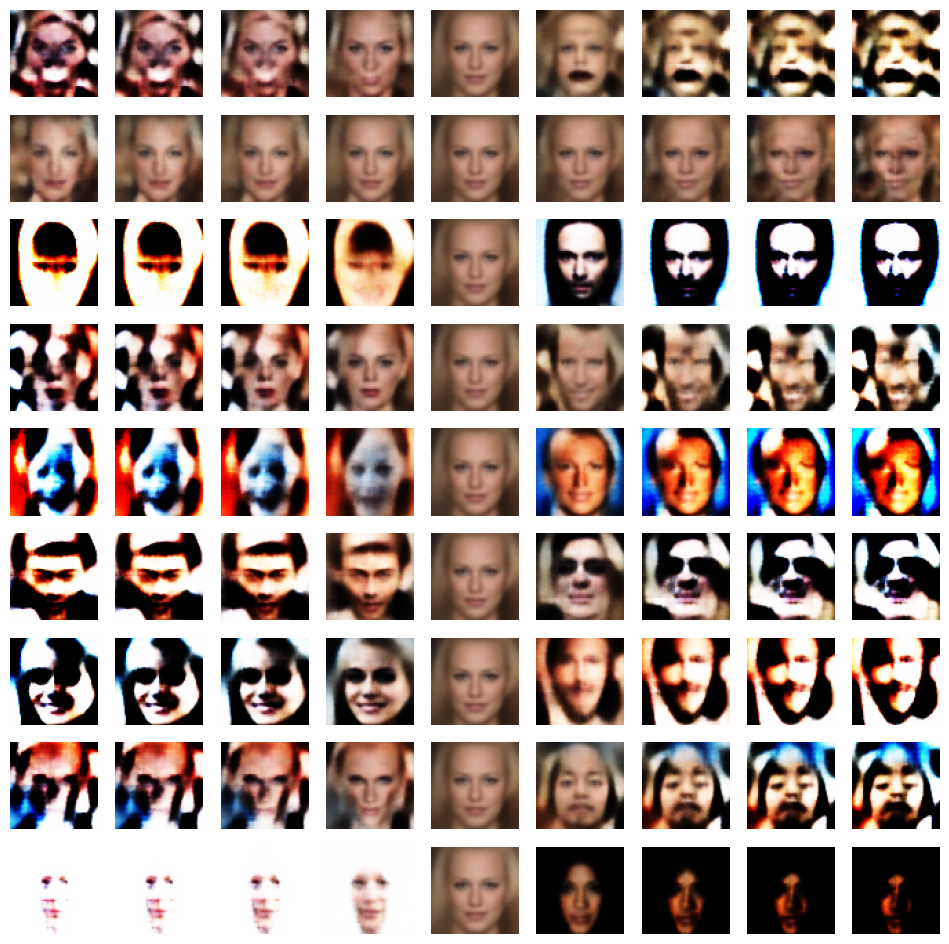

In [48]:
vae = load_vae('model2')
# Ispitivanje lica iz dubina pakla latentnog prostora
plot_faces_with_changes(vae, seed=4, sample_range_start=-60.0, sample_range_end=60.0)